# DALEC-GRASS tutorial 

Vasilis Myrgiotis | 02.06.2022 
University of Edinburgh | Global Change Ecology Lab  

This is a tutorial on using DALEC-Grass. The tutorial has 3 sections 

1. DALEC-Grass code
2. DALEC-Grass inputs
3. Model data fusion with DALEC-Grass

## Viewing the jupyter notebook 

To view this jupyter notebook please take the following steps:

1. ssh to username@burn.geos.ed.ac.uk 
2. create a conda environment by running: "conda create -n dalec_grass python=3.9.7"
3. activate the dalec_grass conda env by running: "conda activate dalec_grass"
4. install some python packages: "pip install ipython matplotlib jupyter pandas numpy spotpy wand salem convertbng geopandas motionless"
5. copy the tutorial's folder to your home dir "cp /disk/scratch/local/DALEC_Grass_tutorial /home/username" or clone the github repo "git clone https://github.com/vmyrgiotis/MDF_DALEC_GRASS.git"

## DALEC-GRASS 

DALEC-Grass is a grassland specific version of DALEC that was developed from DALEC_GIS_DFOL_FR.f90. It is written in fortran and its code is available on github (https://github.com/GCEL/DALEC-Grass). Since DALEC-Grass is work in progress the "latest version" is not on the github repo.


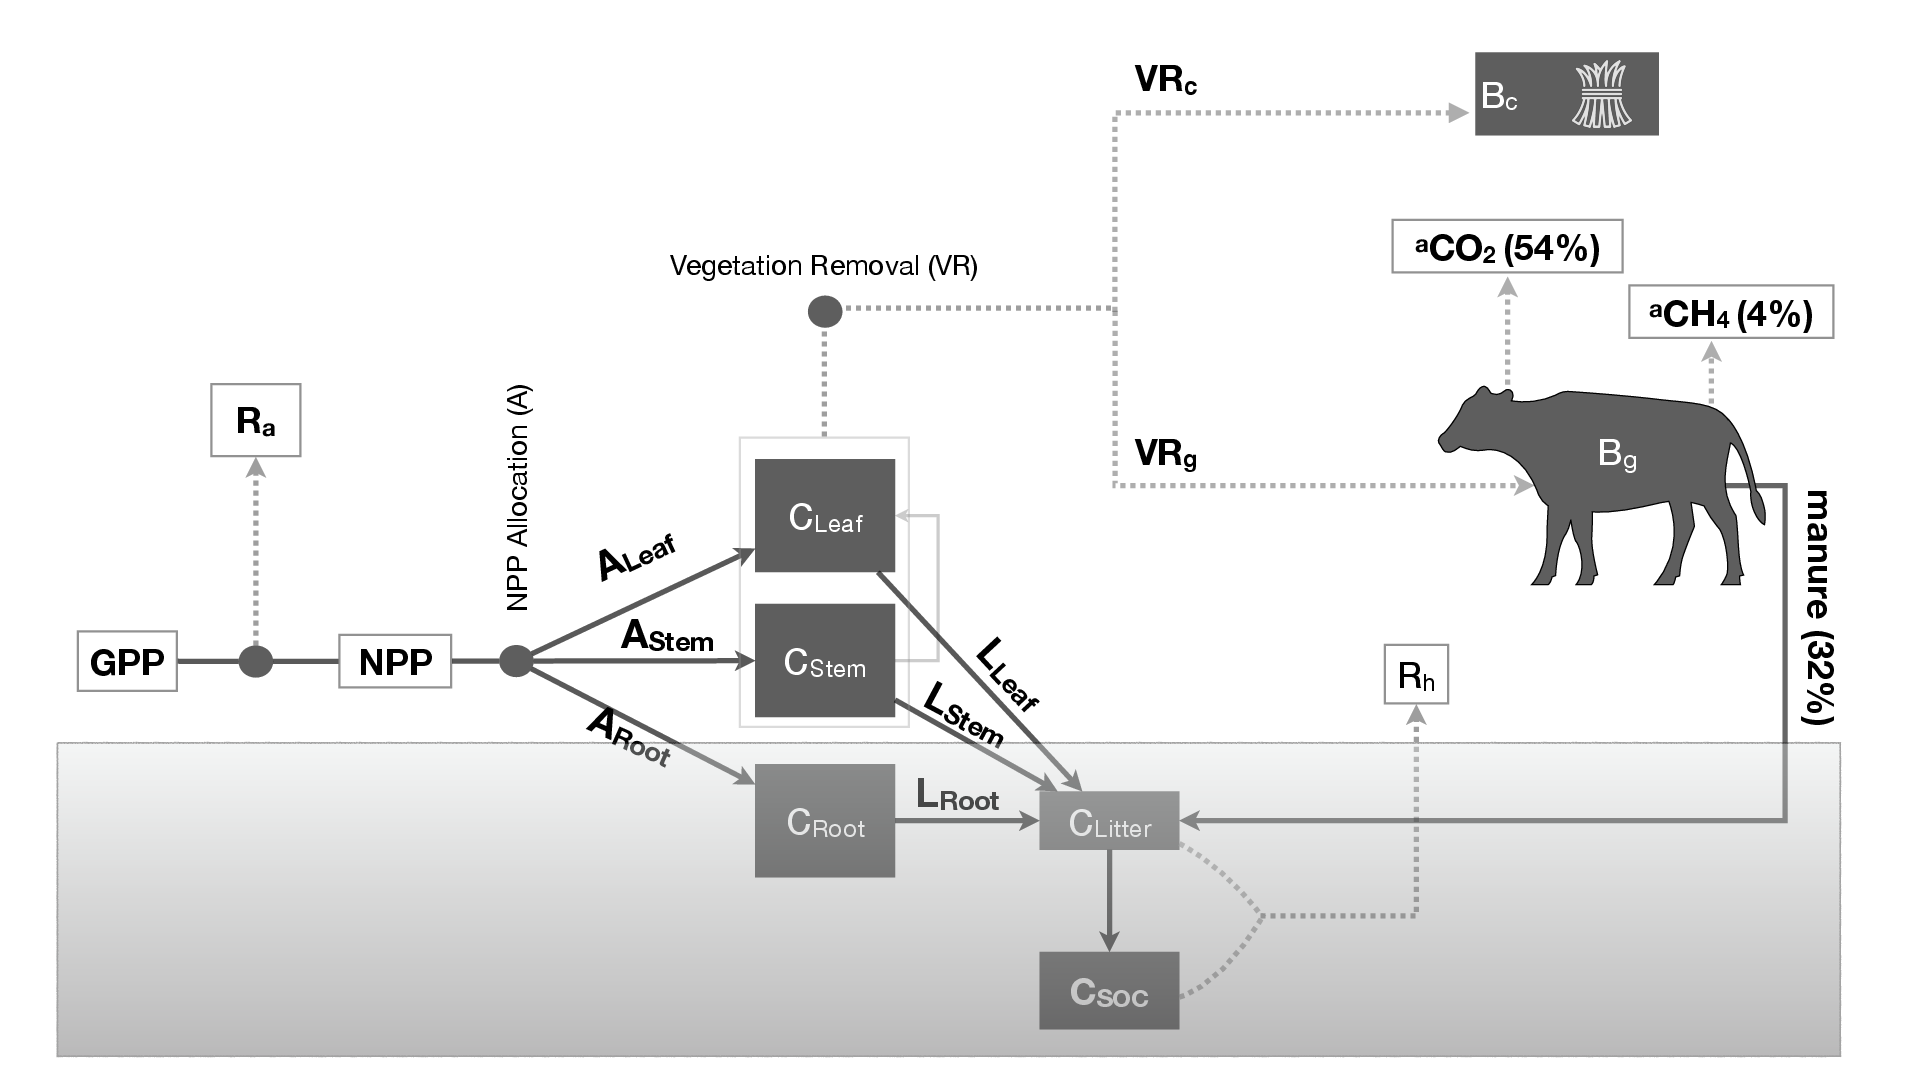

In [11]:
# import necessary packages
%matplotlib inline
from wand. image import Image as WImage
import salem
from convertbng.util import convert_bng, convert_lonlat
import geopandas as gpd 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

# Plot a schematic of the DALEC-Grass model
img = WImage(filename='dalec_grass.pdf')
img


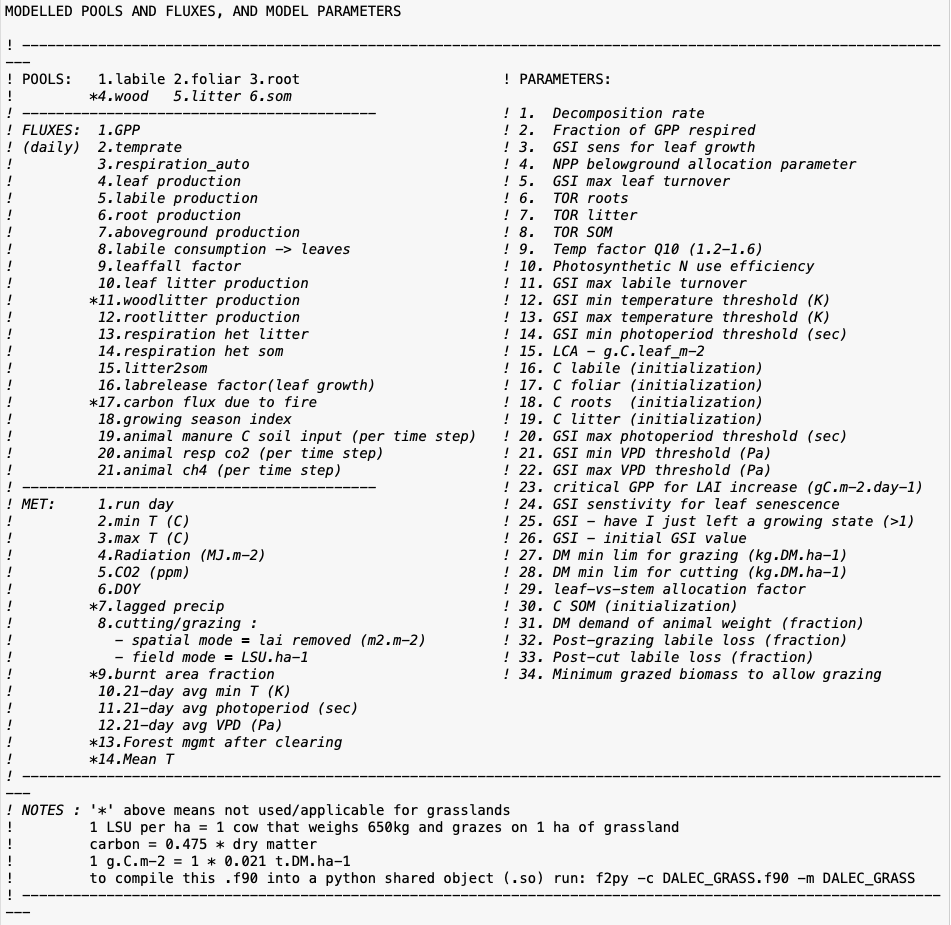

In [12]:
# Show some basic info on DALEC-Grass pools, fluxes, parameters and units
img = WImage(filename='dalec_pars.png')
img

I am using DALEC-Grass in python. The fortran code will be integrated into the DALEC/CARDAMOM structure soon. 

There are python scipts packaged and available from github that allow the user to :

1. source climate and optical/radar EO data form Alaska Satellite Facility, AWS and ECMWF (user accounts needed)
2. process them into time-series for weather variables and LAI observations (storage/RAM demands)
3. implement different probabilistic parameter optimisation algorithms (with/without paralellisation)

The MDF_DALEC_GRASS package can be (1) cloned from github and (2) installed and (3) DALEC_GRASS.f90 can be compilled by running these 3 lines : 

In [13]:
### uncomment the folowing lines if you want to run them
! python setup.py install # install package
! f2py -c DALEC_GRASS.f90 -m DALEC_GRASS # compile the DALEC_GRASS.f90 into a python object 

running install
/Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing MDF_DALEC_GRASS.egg-info/PKG-INFO
writing dependency_links to MDF_DALEC_GRASS.egg-info/dependency_links.txt
writing requirements to MDF_DALEC_GRASS.egg-info/requires.txt
writing top-level names to MDF_DALEC_GRASS.egg-info/top_level.txt
reading manifest file 'MDF_DALEC_GRASS.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'MDF_DALEC_GRASS.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib


Searching for typing-inspect==0.7.1
Best match: typing-inspect 0.7.1
Processing typing_inspect-0.7.1-py3.9.egg
typing-inspect 0.7.1 is already the active version in easy-install.pth

Using /Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/typing_inspect-0.7.1-py3.9.egg
Searching for marshmallow-enum==1.5.1
Best match: marshmallow-enum 1.5.1
Processing marshmallow_enum-1.5.1-py3.9.egg
marshmallow-enum 1.5.1 is already the active version in easy-install.pth

Using /Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/marshmallow_enum-1.5.1-py3.9.egg
Searching for marshmallow==3.16.0
Best match: marshmallow 3.16.0
Processing marshmallow-3.16.0-py3.9.egg
marshmallow 3.16.0 is already the active version in easy-install.pth

Using /Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/marshmallow-3.16.0-py3.9.egg
Searching for threadpoolctl==3.1.0
Best match: threadpoolctl 3.1.0
Processing threadpoolctl-3.1.0-py3.9.egg
threadpoolctl 3.1.0 is already the

In file included from /var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/src.macosx-10.9-x86_64-3.9/DALEC_GRASSmodule.c:20:
In file included from /var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/src.macosx-10.9-x86_64-3.9/fortranobject.h:13:
In file included from /Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1960:
/Users/vm/miniconda3/envs/dalec_grass/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /va

INFO: /usr/local/bin/gfortran -Wall -g -arch x86_64 -Wall -g -undefined dynamic_lookup -bundle /var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/src.macosx-10.9-x86_64-3.9/DALEC_GRASSmodule.o /var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/src.macosx-10.9-x86_64-3.9/fortranobject.o /var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/DALEC_GRASS.o /var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/tmpv78uet7r/src.macosx-10.9-x86_64-3.9/DALEC_GRASS-f2pywrappers2.o -L/usr/local/Cellar/gcc/11.3.0_1/bin/../lib/gcc/11/gcc/x86_64-apple-darwin21/11 -L/usr/local/Cellar/gcc/11.3.0_1/bin/../lib/gcc/11/gcc/x86_64-apple-darwin21/11/../../.. -L/usr/local/Cellar/gcc/11.3.0_1/bin/../lib/gcc/11/gcc/x86_64-apple-darwin21/11/../../.. -lgfortran -o ./DALEC_GRASS.cpython-39-darwin.so
ld: warning: dy

In [14]:
! ls -lh

total 3952
-rwxr-xr-x  1 vm  staff    75K  2 Jun 12:29 DALEC_GRASS.cpython-39-darwin.so
-rw-r--r--  1 vm  staff    34K  2 Jun 12:24 DALEC_GRASS.f90
-rw-r--r--  1 vm  staff   6.9K  2 Jun 12:24 LICENSE
-rw-r--r--  1 vm  staff   7.0K  2 Jun 12:24 MDF.py
drwxr-xr-x@ 7 vm  staff   224B  2 Jun 12:29 MDF_DALEC_GRASS.egg-info
-rw-r--r--  1 vm  staff   2.5K  2 Jun 12:24 README.md
-rw-r--r--  1 vm  staff     1B  2 Jun 12:24 __init__.py
drwxr-xr-x@ 3 vm  staff    96B  2 Jun 12:26 build
-rw-r--r--  1 vm  staff   561K  2 Jun 12:24 dalec_grass.pdf
-rw-r--r--  1 vm  staff   967K  2 Jun 12:29 dalec_grass_tutorial.ipynb
-rw-r--r--  1 vm  staff   238K  2 Jun 12:24 dalec_pars.png
drwxr-xr-x@ 3 vm  staff    96B  2 Jun 12:26 dist
-rw-r--r--  1 vm  staff   441B  2 Jun 12:24 greatfield.geojson
-rw-r--r--  1 vm  staff    23K  2 Jun 12:24 greatfield_M.npy
-rw-r--r--  1 vm  staff   1.8K  2 Jun 12:24 greatfield_O.npy
-rw-r--r--  1 vm  staff    31K  2 Jun 12:24 input_data_production.py
-rw-r--r--  1 vm  staff   9

## DALEC-Grass inputs 

The standard DALEC inputs needed with the GSI module : min/max T, srad, photoperiod, VPD, atm CO2 PLUS information on what is happening to the vegetation of a grassland field i.e. changes in volume. 

Vegetation volume change inputs are, in essence, a time-series of week-to-week reduction in LAI (in total m2.m-2 per week, can be zero or positive).

The input_data_procuction module of the MDF_DALEC_GRASS package handles input data creation. Provided with a polygon (field limits) and a start/end date it will: 

1. source raw met (ECMWF) and EO (ASF,AWS) data 
2. process them into met and veg_reduction time-series; and into
3. observational LAI time-series, based on fusing optical (sentinel-2) and radar (sentinel-1) data

Steps 1-3 take time (Step1: 20%, Step2: 30%, Step3: 50% of total duration).



/var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/ipykernel_19679/3549953870.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for g, geo in enumerate(gdf.geometry) : sm.set_geometry(geo,alpha=0.75,facecolor=cmap(gdf.area.iloc[g]/(gdf.area.max()-gdf.area.min())))
/var/folders/49/l8z8_mqs3ld4vsjn17w5wth40000gn/T/ipykernel_19679/3549953870.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  for g, geo in enumerate(gdf.geometry) : sm.set_geometry(geo,alpha=0.75,facecolor=cmap(gdf.area.iloc[g]/(gdf.area.max()-gdf.area.min())))


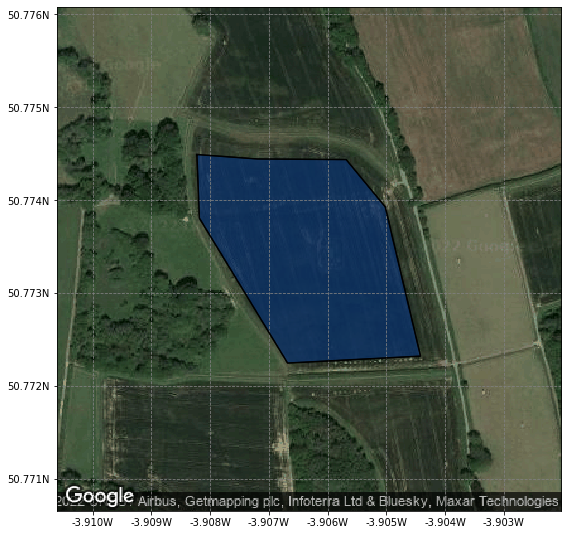

In [15]:
# Example site location and limits
gdf = gpd.read_file('greatfield.geojson') # a geojson or shapefile with the location of the site
gdf = gdf.to_crs(epsg=4326)
gdf[['minx','miny','maxx','maxy']] = gdf.geometry.bounds

## Get the google map basemap
xdist = (gdf.minx.min() - gdf.maxx.max())*1.5
ydist = (gdf.miny.min() - gdf.maxy.max())*1.5
g = salem.GoogleVisibleMap(x=[gdf.minx.min()-xdist, gdf.maxx.max()+xdist],
                           y=[gdf.miny.min()-ydist, gdf.maxy.max()+ydist],
                           maptype='satellite', scale=1,
                           size_x=400, size_y=400)
ggl_img = g.get_vardata()

sm = salem.Map(g.grid, factor=1, countries=False)
sm.set_rgb(ggl_img,)  # add the background rgb image
cmap = plt.get_cmap('Blues')
for g, geo in enumerate(gdf.geometry) : sm.set_geometry(geo,alpha=0.75,facecolor=cmap(gdf.area.iloc[g]/(gdf.area.max()-gdf.area.min())))

# plot!
f, ax = plt.subplots(figsize=(10, 8))
ax.set_position([0.05, 0.06, 0.7, 0.9])
sm.visualize(ax=ax)
plt.show()



In [16]:
drivers = np.load('greatfield_M.npy') # load met/veg_red time-series
drivers.shape # see above for basic info on DALEC-Grass pools, fluxes, parameters and units 

(14, 208)

In [17]:
years = drivers.shape[1]/52
years # how many years simulated 

4.0

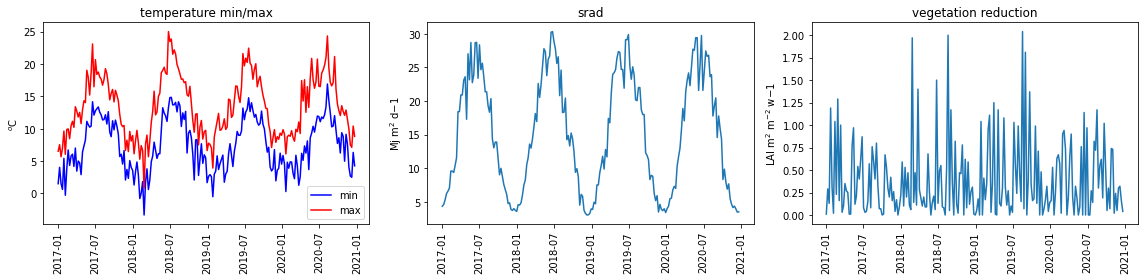

In [18]:
# preview met/management time-series
inputs = pd.DataFrame(drivers)
inputs = inputs.T
inputs.index = pd.date_range('2017-01-01', periods = drivers.shape[1], freq='W') 
inputs = inputs.rename(columns={inputs.columns[1]: 'minT'}) 
inputs = inputs.rename(columns={inputs.columns[2]: 'maxT'}) 
inputs = inputs.rename(columns={inputs.columns[3]: 'srad'}) 
inputs = inputs.rename(columns={inputs.columns[7]: 'veg_red'}) 

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title('temperature min/max')
plt.ylabel('$^{o}$C')
plt.plot(inputs.minT,label='min',color='blue')
plt.plot(inputs.maxT,label='max',color='red')
plt.xticks(rotation=90)
plt.legend()
plt.subplot(1, 3, 2)
plt.title('srad')
plt.ylabel('Mj m$^{2}$ d${-1}$')
plt.plot(inputs.srad)
plt.xticks(rotation=90)
plt.subplot(1, 3, 3)
plt.title('vegetation reduction')
plt.ylabel('LAI m$^{2}$ m$^{-2}$ w${-1}$')
plt.plot(inputs.veg_red)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



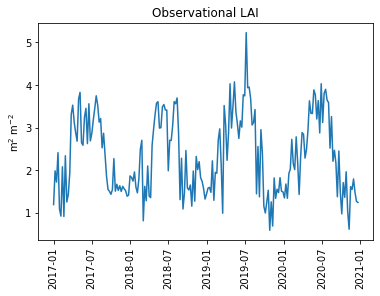

In [20]:
# preview observational LAI time-series
laiobs = np.load('greatfield_O.npy')
laiobs = pd.DataFrame(laiobs)
laiobs.index = pd.date_range('2017-01-01', periods = len(laiobs), freq='W') 
laiobs = laiobs.rename(columns={inputs.columns[0]: 'lai'})
plt.plot(laiobs.lai)
plt.xticks(rotation=90)
plt.title('Observational LAI')
plt.ylabel('m$^{2}$ m$^{-2}$')
plt.show()

## Model data fusion with DALEC-Grass

The MDF algorithm is implemented by calling the run() function of the MDF_DALEC_GRASS packae.

The run() function can be parallelised to speedup the assimilation duration. 

You can uncomment the following block of code and run it. This will replace the existing MDF_outs_xxxxxxxx.csv file that contains information on the posteriors of the 34 DALEC-Grass parameters. MDF.run() can take between 15-30 mins to complete on burn.

• Note that if you have copied the tutorial's folder to your home dir you need to edit the workingdir before calling the MDF.run() function below.

In [ ]:
# from MDF_DALEC_GRASS import MDF # import model-data fusion code 
MDF.run(workingdir="/disk/scratch/local/DALEC_Grass_tutorial/MDF_DALEC_GRASS",sitename='greatfield') 

Initializing the  Simulated Annealing (SA) algorithm  with  10000000  repetitions
The objective function will be maximized
Starting the SA algotrithm with 10000000 repetitions...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file '/disk/scratch/local/DALEC_Grass_tutorial/MDF_DALEC_GRASS/MDF_outs_greatfield.csv' created.


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

502 of 10000000, maximal objective function=-1e+308, time remaining: 11:03:37


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

688 of 10000000, maximal objective function=-1e+308, time remaining: 16:10:57


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

915 of 10000000, maximal objective function=-1e+308, time remaining: 18:16:05


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

1211 of 10000000, maximal objective function=-1e+308, time remaining: 18:23:34


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

2215 of 10000000, maximal objective function=-1e+308, time remaining: 12:34:47


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

2456 of 10000000, maximal objective function=-1e+308, time remaining: 13:36:44


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

2940 of 10000000, maximal objective function=-1e+308, time remaining: 13:16:05


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

3330 of 10000000, maximal objective function=-1e+308, time remaining: 13:23:13


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid value encountered in double_scalars
  dE = Eold - Enew
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/spotpy/algorithms/sa.py:125: RuntimeWarning: invalid

3779 of 10000000, maximal objective function=-1.85486, time remaining: 13:16:02
3962 of 10000000, maximal objective function=-1.34804, time remaining: 14:03:32
4143 of 10000000, maximal objective function=-1.20768, time remaining: 14:47:08
4358 of 10000000, maximal objective function=-1.02025, time remaining: 15:20:00
4549 of 10000000, maximal objective function=-1.02025, time remaining: 15:54:56
4730 of 10000000, maximal objective function=-0.888219, time remaining: 16:28:54
4913 of 10000000, maximal objective function=-0.888219, time remaining: 17:00:14
5090 of 10000000, maximal objective function=-0.888219, time remaining: 17:30:28
5333 of 10000000, maximal objective function=-0.888219, time remaining: 17:45:06
5530 of 10000000, maximal objective function=-0.888219, time remaining: 18:07:45
5701 of 10000000, maximal objective function=-0.888219, time remaining: 18:33:35
5867 of 10000000, maximal objective function=-0.888219, time remaining: 18:58:53
6034 of 10000000, maximal objecti

23215 of 10000000, maximal objective function=-0.794174, time remaining: 02:20:54
23436 of 10000000, maximal objective function=-0.794174, time remaining: 02:20:13
23628 of 10000000, maximal objective function=-0.794174, time remaining: 02:21:27
23813 of 10000000, maximal objective function=-0.794174, time remaining: 02:23:10
23984 of 10000000, maximal objective function=-0.794174, time remaining: 02:25:47
24195 of 10000000, maximal objective function=-0.794174, time remaining: 02:25:44
24388 of 10000000, maximal objective function=-0.794174, time remaining: 02:26:49
24581 of 10000000, maximal objective function=-0.794174, time remaining: 02:27:52
24775 of 10000000, maximal objective function=-0.794174, time remaining: 02:28:50
24998 of 10000000, maximal objective function=-0.794174, time remaining: 02:27:56
25155 of 10000000, maximal objective function=-0.794174, time remaining: 02:31:17
25314 of 10000000, maximal objective function=-0.794174, time remaining: 02:34:29
25502 of 1000000

42990 of 10000000, maximal objective function=-0.794174, time remaining: 03:06:22
43166 of 10000000, maximal objective function=-0.794174, time remaining: 03:07:24
43358 of 10000000, maximal objective function=-0.794174, time remaining: 03:07:50
43543 of 10000000, maximal objective function=-0.794174, time remaining: 03:08:32
43759 of 10000000, maximal objective function=-0.794174, time remaining: 03:08:05
43958 of 10000000, maximal objective function=-0.794174, time remaining: 03:08:14
44178 of 10000000, maximal objective function=-0.794174, time remaining: 03:07:37
44381 of 10000000, maximal objective function=-0.794174, time remaining: 03:07:38
44552 of 10000000, maximal objective function=-0.794174, time remaining: 03:08:50
44742 of 10000000, maximal objective function=-0.794174, time remaining: 03:09:20
44966 of 10000000, maximal objective function=-0.794174, time remaining: 03:08:34
45153 of 10000000, maximal objective function=-0.794174, time remaining: 03:09:10
45325 of 1000000

62847 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:01
63036 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:19
63243 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:11
63533 of 10000000, maximal objective function=-0.794174, time remaining: 03:16:53
63723 of 10000000, maximal objective function=-0.794174, time remaining: 03:17:11
63919 of 10000000, maximal objective function=-0.794174, time remaining: 03:17:20
64090 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:07
64284 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:19
64499 of 10000000, maximal objective function=-0.794174, time remaining: 03:17:59
64698 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:03
64872 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:44
65080 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:34
65255 of 1000000

82926 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:33
83103 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:01
83298 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:06
83482 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:26
83703 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:02
83905 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:00
84091 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:18
84329 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:33
84514 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:52
84717 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:50
84902 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:08
85094 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:17
85290 of 1000000

102945 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:27
103152 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:21
103352 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:20
103558 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:14
103782 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:51
104040 of 10000000, maximal objective function=-0.794174, time remaining: 03:17:55
104247 of 10000000, maximal objective function=-0.794174, time remaining: 03:17:49
104421 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:14
104623 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:11
104820 of 10000000, maximal objective function=-0.794174, time remaining: 03:18:14
105063 of 10000000, maximal objective function=-0.794174, time remaining: 03:17:34
105308 of 10000000, maximal objective function=-0.794174, time remaining: 03:16:51
1055

122600 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:37
122816 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:22
122996 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:38
123179 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:51
123409 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:25
123618 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:17
123800 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:30
124023 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:11
124245 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:52
124438 of 10000000, maximal objective function=-0.794174, time remaining: 03:19:57
124613 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:15
124827 of 10000000, maximal objective function=-0.794174, time remaining: 03:20:03
1250

142633 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:03
142814 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:16
142992 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:30
143202 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:21
143406 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:18
143605 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:18
143795 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:23
143978 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:34
144183 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:29
144418 of 10000000, maximal objective function=-0.784194, time remaining: 03:16:04
144678 of 10000000, maximal objective function=-0.784194, time remaining: 03:15:21
144878 of 10000000, maximal objective function=-0.784194, time remaining: 03:15:21
1451

162467 of 10000000, maximal objective function=-0.784194, time remaining: 03:13:49
162648 of 10000000, maximal objective function=-0.784194, time remaining: 03:13:59
162844 of 10000000, maximal objective function=-0.784194, time remaining: 03:14:01
163055 of 10000000, maximal objective function=-0.784194, time remaining: 03:13:53
163250 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:55
163447 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:55
163654 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:50
163853 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:49
164065 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:40
164254 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:46
164457 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:43
164651 of 10000000, maximal objective function=-0.737386, time remaining: 03:13:45
1648

182164 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:38
182342 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:48
182585 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:24
182760 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:36
182973 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:27
183167 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:29
183362 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:30
183562 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:28
183853 of 10000000, maximal objective function=-0.737386, time remaining: 03:11:37
184062 of 10000000, maximal objective function=-0.737386, time remaining: 03:11:31
184245 of 10000000, maximal objective function=-0.737386, time remaining: 03:11:39
184454 of 10000000, maximal objective function=-0.737386, time remaining: 03:11:33
1846

201659 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:40
201881 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:27
202070 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:30
202282 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:23
202458 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:33
202638 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:41
202822 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:47
203020 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:46
203201 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:54
203442 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:32
203674 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:15
203886 of 10000000, maximal objective function=-0.737386, time remaining: 03:12:07
2040

221465 of 10000000, maximal objective function=-0.737386, time remaining: 03:09:47
221739 of 10000000, maximal objective function=-0.737386, time remaining: 03:09:12
221963 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:59
222184 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:48
222395 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:41
222604 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:35
222846 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:15
223039 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:17
223233 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:18
223411 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:26
223591 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:33
223766 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:43
2239

240953 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:59
241227 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:27
241423 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:27
241610 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:30
241817 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:25
242044 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:12
242256 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:05
242429 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:15
242604 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:23
242775 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:33
242970 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:33
243154 of 10000000, maximal objective function=-0.737386, time remaining: 03:08:38
2433

260619 of 10000000, maximal objective function=-0.737386, time remaining: 03:06:40
260787 of 10000000, maximal objective function=-0.737386, time remaining: 03:06:50
260955 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:01
261145 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:03
261347 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:00
261549 of 10000000, maximal objective function=-0.737386, time remaining: 03:06:58
261721 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:07
261909 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:10
262087 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:16
262277 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:18
262469 of 10000000, maximal objective function=-0.737386, time remaining: 03:07:19
262725 of 10000000, maximal objective function=-0.737386, time remaining: 03:06:55
2629

When the assimilation is completed we can draw samples from the posterior distribution and run DALEC-Grass in forward mode to obtain estimates of C pools, fluxes and balance. The following block of code completes such forward runs.

• Note that if you have copied the tutorial's folder to your home dir you need to edit the workingdir string below.

In [10]:
# forward runs 
import numpy as np 
import pandas as pd 
import DALEC_GRASS
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime
import matplotlib.pyplot as plt 
from scipy import stats

workingdir = "/disk/scratch/local/DALEC_Grass_tutorial/MDF_DALEC_GRASS"
sitename = 'greatfield'

# load posteriors
mcmc_outs = pd.read_csv('MDF_DALEC_GRASS/MDF_outs_%s.csv'%sitename)
mcmc_outs = mcmc_outs.sort_values(by='like1',ascending=False)
mcmc_outs = mcmc_outs[:100]
    
## Load drivers 
met       = np.array(np.load('%s/%s_M.npy' %(workingdir,sitename)),order="F")   
met       = np.append(met[:,:52],met,axis=1) ## add 1 spinup year 
met[0,:]  = np.arange(1,len(met[0,:])+1) ## re-create index 

## Fill DALEC-Grass input variables 
deltat   = np.zeros([(met.shape[1])]) + 7 # weekly runs 
nodays   = met.shape[1]
noyears  = int(nodays/float(52)) - 1 # weekly runs 
start    = 1     
finish   = int(nodays)
nopools  = 6     
nofluxes = 21 
nopars   = 34
nomet    = met.shape[0]
lat      = 50.77
VC       = 1

#### Load LAI observations 
obs_lai = np.load("%s/%s_O.npy" %(workingdir,sitename)) 

### Complete forward runs 
nosamples  = len(mcmc_outs)
lai_mult   = np.zeros([(nosamples),nodays]) * np.nan
gpp_mult   = np.zeros([(nosamples),nodays]) * np.nan 
npp_mult   = np.zeros([(nosamples),nodays]) * np.nan 
nee_mult   = np.zeros([(nosamples),nodays]) * np.nan 
nbe_mult   = np.zeros([(nosamples),nodays]) * np.nan 
graze_mult = np.zeros([(nosamples),nodays]) * np.nan 
soilC_mult = np.zeros([(nosamples),nodays+1]) * np.nan 
cut_mult   = np.zeros([(nosamples),nodays]) * np.nan  
abgC_mult  = np.zeros([(nosamples),nodays+1]) * np.nan 
rootC_mult = np.zeros([(nosamples),nodays+1]) * np.nan 
litterC_mult = np.zeros([(nosamples),nodays+1]) * np.nan 
animalCgas_mult = np.zeros([(nosamples),nodays]) * np.nan 
animalCmanure_mult = np.zeros([(nosamples),nodays]) * np.nan 
flux_autresp_mult = np.zeros([(nosamples),nodays]) * np.nan 
flux_hetresp_mult = np.zeros([(nosamples),nodays]) * np.nan 
flux_leaf_mult = np.zeros([(nosamples),nodays])  * np.nan
flux_stem_mult = np.zeros([(nosamples),nodays]) * np.nan 
flux_root_mult = np.zeros([(nosamples),nodays]) * np.nan 
flux_litter_mult = np.zeros([(nosamples),nodays]) * np.nan 
flux_som_mult = np.zeros([(nosamples),nodays]) * np.nan 

unc_DF = pd.DataFrame()

for i in range(0,(nosamples)):

	pars = np.array(mcmc_outs[mcmc_outs.columns[1:(nopars+1)]].iloc[i],order="F")
	lai,gpp,nee,pools,fluxes,rem = DALEC_GRASS.carbon_model_mod.carbon_model(start,finish,deltat,lat,met,pars,nopools,nofluxes,VC,nodays,nopars,nomet)
		
	lai_mult[i,:] = lai
	gpp_mult[i,:] = gpp
	npp_mult[i,:] = gpp - fluxes[:,2] 
	nee_mult[i,:] = nee
	graze_mult[i,:] = rem[0] 
	cut_mult[i,:] = rem[1] 
	soilC_mult[i,:] = pools[:,5]
	abgC_mult[i,:] =  pools[:,0] + pools[:,1]
	rootC_mult[i,:] = pools[:,2]
	litterC_mult[i,:] = pools[:,4]
	nbe_mult[i,:] = nee*7 + (rem[0] + rem[1]) - fluxes[:,18]
	animalCgas_mult[i,:] = fluxes[:,19] + fluxes[:,20]
	animalCmanure_mult[i,:] = fluxes[:,18]
	flux_autresp_mult[i,:] = fluxes[:,2] 
	flux_hetresp_mult[i,:] =  fluxes[:,12] + fluxes[:,13]
	flux_leaf_mult[i,:] = fluxes[:,3] 
	flux_stem_mult[i,:] =  fluxes[:,4] 
	flux_root_mult[i,:] = fluxes[:,5] 
	flux_litter_mult[i,:] =  fluxes[:,9] + fluxes[:,10] + fluxes[:,11]
	flux_som_mult[i,:] =  fluxes[:,14] 

cut_mult[cut_mult==0] = np.nan

for i in range(nodays): 
	unc_DF = unc_DF.append({
			  'lai': stats.bayes_mvs(lai_mult[:,i][~np.isnan(lai_mult[:,i])],alpha=0.99)[0][0] , 
			  'lai_std': stats.bayes_mvs(lai_mult[:,i][~np.isnan(lai_mult[:,i])],alpha=0.99)[2][0],
			  'gpp': stats.bayes_mvs(gpp_mult[:,i][~np.isnan(gpp_mult[:,i])],alpha=0.99)[0][0] , 
			  'gpp_std': stats.bayes_mvs(gpp_mult[:,i][~np.isnan(gpp_mult[:,i])],alpha=0.99)[2][0],
			  'nee': stats.bayes_mvs(nee_mult[:,i][~np.isnan(nee_mult[:,i])],alpha=0.99)[0][0] , 
			  'nee_std': stats.bayes_mvs(nee_mult[:,i][~np.isnan(nee_mult[:,i])],alpha=0.99)[2][0],
			  'npp': stats.bayes_mvs(npp_mult[:,i][~np.isnan(npp_mult[:,i])],alpha=0.99)[0][0] , 
			  'npp_std': stats.bayes_mvs(npp_mult[:,i][~np.isnan(npp_mult[:,i])],alpha=0.99)[2][0],
			  'nbe': stats.bayes_mvs(nbe_mult[:,i][~np.isnan(nbe_mult[:,i])],alpha=0.99)[0][0] , 
			  'nbe_std': stats.bayes_mvs(nbe_mult[:,i][~np.isnan(nbe_mult[:,i])],alpha=0.99)[2][0],
			  'graze_prob': len(graze_mult[:,i][graze_mult[:,i]>0])/float(len(graze_mult[:,i])),
			  'graze': stats.bayes_mvs(graze_mult[:,i][~np.isnan(graze_mult[:,i])],alpha=0.99)[0][0] , 
			  'graze_std': stats.bayes_mvs(graze_mult[:,i][~np.isnan(graze_mult[:,i])],alpha=0.99)[2][0],
			  'cut_prob': len(cut_mult[:,i][cut_mult[:,i]>0])/float(len(cut_mult[:,i])),
			  'cut_mean' : np.nanmean(cut_mult[:,i]),
			  'cut_std' : np.nanstd(cut_mult[:,i]),	  
			  'soilC': stats.bayes_mvs(soilC_mult[:,i][~np.isnan(soilC_mult[:,i])],alpha=0.99)[0][0] , 
			  'soilC_std': stats.bayes_mvs(soilC_mult[:,i][~np.isnan(soilC_mult[:,i])],alpha=0.99)[2][0],
			  'abgC': stats.bayes_mvs(abgC_mult[:,i][~np.isnan(abgC_mult[:,i])],alpha=0.99)[0][0] , 
			  'abgC_std': stats.bayes_mvs(abgC_mult[:,i][~np.isnan(abgC_mult[:,i])],alpha=0.99)[2][0],
			  'rootC': stats.bayes_mvs(rootC_mult[:,i][~np.isnan(rootC_mult[:,i])],alpha=0.99)[0][0] , 
			  'rootC_std': stats.bayes_mvs(rootC_mult[:,i][~np.isnan(rootC_mult[:,i])],alpha=0.99)[2][0],
			  'litterC': stats.bayes_mvs(litterC_mult[:,i][~np.isnan(litterC_mult[:,i])],alpha=0.99)[0][0] , 
			  'litterC_std': stats.bayes_mvs(litterC_mult[:,i][~np.isnan(litterC_mult[:,i])],alpha=0.99)[2][0],
			  'animalCgas': stats.bayes_mvs(animalCgas_mult[:,i][~np.isnan(animalCgas_mult[:,i])],alpha=0.99)[0][0] , 
			  'animalCgas_std': stats.bayes_mvs(animalCgas_mult[:,i][~np.isnan(animalCgas_mult[:,i])],alpha=0.99)[2][0],
			  'animalCmanure': stats.bayes_mvs(animalCmanure_mult[:,i][~np.isnan(animalCmanure_mult[:,i])],alpha=0.99)[0][0] , 
			  'animalCmanure_std': stats.bayes_mvs(animalCmanure_mult[:,i][~np.isnan(animalCmanure_mult[:,i])],alpha=0.99)[2][0],
			  'autresp': stats.bayes_mvs(flux_autresp_mult[:,i][~np.isnan(flux_autresp_mult[:,i])],alpha=0.99)[0][0], 
			  'autresp_std': stats.bayes_mvs(flux_autresp_mult[:,i][~np.isnan(flux_autresp_mult[:,i])],alpha=0.99)[2][0],
			  'hetresp': stats.bayes_mvs(flux_hetresp_mult[:,i][~np.isnan(flux_hetresp_mult[:,i])],alpha=0.99)[0][0], 
			  'hetresp_std': stats.bayes_mvs(flux_hetresp_mult[:,i][~np.isnan(flux_hetresp_mult[:,i])],alpha=0.99)[2][0],			  
			  'F_leaf': stats.bayes_mvs(flux_leaf_mult[:,i][~np.isnan(flux_leaf_mult[:,i])],alpha=0.99)[0][0], 
			  'F_leaf_std': stats.bayes_mvs(flux_leaf_mult[:,i][~np.isnan(flux_leaf_mult[:,i])],alpha=0.99)[2][0],
			  'F_stem': stats.bayes_mvs(flux_stem_mult[:,i][~np.isnan(flux_stem_mult[:,i])],alpha=0.99)[0][0], 
			  'F_stem_std': stats.bayes_mvs(flux_stem_mult[:,i][~np.isnan(flux_stem_mult[:,i])],alpha=0.99)[2][0],
			  'F_root': stats.bayes_mvs(flux_root_mult[:,i][~np.isnan(flux_root_mult[:,i])],alpha=0.99)[0][0], 
			  'F_root_std': stats.bayes_mvs(flux_root_mult[:,i][~np.isnan(flux_root_mult[:,i])],alpha=0.99)[2][0],			  			  
			  'F_litter': stats.bayes_mvs(flux_litter_mult[:,i][~np.isnan(flux_litter_mult[:,i])],alpha=0.99)[0][0], 
			  'F_litter_std': stats.bayes_mvs(flux_litter_mult[:,i][~np.isnan(flux_litter_mult[:,i])],alpha=0.99)[2][0],
			  'F_som': stats.bayes_mvs(flux_som_mult[:,i][~np.isnan(flux_som_mult[:,i])],alpha=0.99)[0][0], 
			  'F_som_std': stats.bayes_mvs(flux_som_mult[:,i][~np.isnan(flux_som_mult[:,i])],alpha=0.99)[2][0]			  
			  },ignore_index=True)

unc_DF.index = pd.date_range('2016-01-08', periods = nodays, freq='7D')
unc_DF = unc_DF['2017':]


/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/scratch/vmyrgiot/miniconda3/envs/py3VM/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [11]:
# what did the forward runs produce 
unc_DF # the dataframe holding DALEC-Grass predictions (mean and std) for C pools, fluxes and removals

,F_leaf,F_leaf_std,F_litter,F_litter_std,F_root,F_root_std,F_som,F_som_std,F_stem,F_stem_std,...,nbe,nbe_std,nee,nee_std,npp,npp_std,rootC,rootC_std,soilC,soilC_std
2017-01-06,0.342052,0.164364,0.722615,0.588772,0.481114,0.332798,0.405264,0.377196,0.068311,0.062945,...,4.517638,5.150775,0.565904,0.748034,0.891477,0.503238,84.165948,214.446758,20719.472308,647.981170
2017-01-13,0.410123,0.120863,0.709842,0.565542,0.572034,0.340157,0.399251,0.389723,0.081401,0.065849,...,6.898602,4.795836,0.451717,0.689838,1.063558,0.451947,82.484441,212.772741,20716.008907,648.455047
2017-01-20,0.460068,0.132200,0.724271,0.535936,0.608317,0.356556,0.381443,0.372968,0.086663,0.069633,...,3.863027,4.465599,0.250190,0.669091,1.155048,0.475392,81.528305,211.178008,20711.974175,648.850442
2017-01-27,0.521718,0.145033,0.740233,0.513095,0.702304,0.399760,0.382763,0.366973,0.099290,0.078541,...,7.491627,10.671165,0.091897,0.661494,1.323312,0.526191,80.725661,209.657172,20708.462511,649.234356
2017-02-03,0.580235,0.156205,0.773786,0.498411,0.652215,0.344139,0.552416,0.640083,0.089641,0.056600,...,7.314597,6.996938,0.496858,0.827415,1.322091,0.432390,80.469035,208.258991,20704.902195,649.558578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-27,0.326044,0.169503,1.394466,1.429698,0.333779,0.281637,0.654610,0.538705,0.047219,0.040411,...,9.404063,5.622166,1.197505,0.843368,0.707043,0.432527,115.568895,335.456106,20423.174223,841.738411
2020-12-04,0.326128,0.181784,1.227089,1.495999,0.344590,0.293825,0.595162,0.617210,0.049059,0.042727,...,10.442383,6.107706,1.006893,0.940555,0.719778,0.463995,111.598254,333.146983,20420.680656,843.346642
2020-12-11,0.286542,0.168137,1.328275,1.805763,0.268027,0.231584,0.680370,0.857696,0.039671,0.036180,...,9.861072,6.483237,1.138006,0.931114,0.594240,0.394382,108.383351,330.952042,20418.378365,844.960683
2020-12-18,0.241562,0.161336,0.767883,0.746574,0.220608,0.211532,0.762335,0.912964,0.032926,0.033482,...,12.383073,8.181744,1.554778,1.233491,0.495096,0.371957,105.112448,328.673334,20416.757488,846.204457


## Plotting the results of forward runs

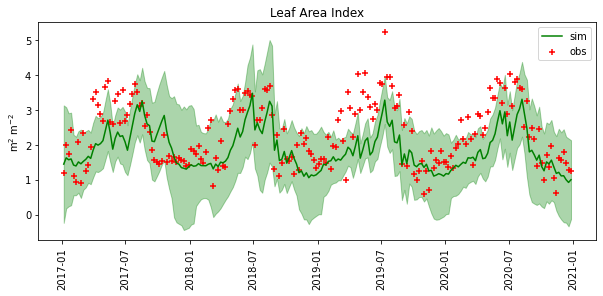

In [33]:
## Leaf Area Index 
plt.figure(figsize=(8, 4))
plt.title('Leaf Area Index')
plt.ylabel('m$^{2}$ m$^{-2}$')
plt.plot(unc_DF.lai,color='green',label='sim')
plt.fill_between(unc_DF.index, unc_DF.lai + 2*unc_DF['lai_std'], unc_DF.lai - 2*unc_DF['lai_std'], color='green', alpha=0.33)
plt.scatter(unc_DF.index,obs_lai,marker='+',color='red',label='obs')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
## NEE 
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.title('NEE')
plt.ylabel('g C m$^{-2}$ d$^{-1}$')
plt.plot(unc_DF.nee,color='black')
plt.fill_between(unc_DF.index, unc_DF.nee + 2*unc_DF['nee_std'], unc_DF.nee - 2*unc_DF['nee_std'], color='black', alpha=0.33)
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.plot(unc_DF.nee.cumsum(),color='black')
plt.ylabel('g C m$^{-2}$')
plt.xticks(rotation=90)
plt.show()

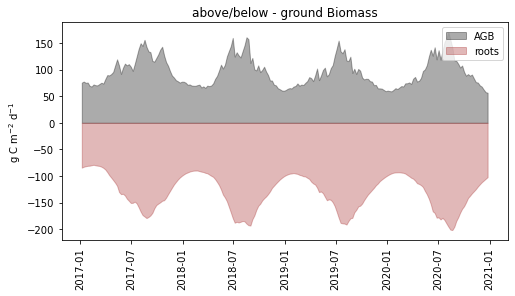

In [43]:
## AGB 
plt.figure(figsize=(8, 4))
plt.title('above/below - ground Biomass')
plt.fill_between(unc_DF.index, unc_DF.abgC, unc_DF.abgC*0 , color='black', alpha=0.33,label='AGB')
plt.fill_between(unc_DF.index, -unc_DF.rootC, unc_DF.rootC*0 , color='brown', alpha=0.33,label='roots')
plt.ylabel('g C m$^{-2}$')
plt.xticks(rotation=90)
plt.legend()
plt.show()

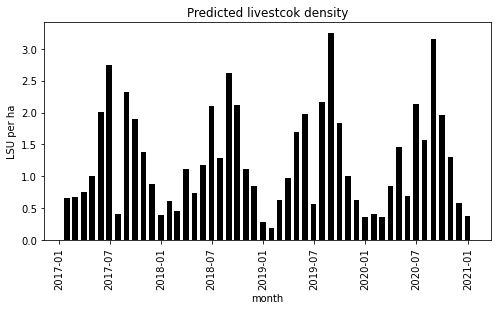

In [34]:
## Grazing 
plt.figure(figsize=(8, 4))
plt.title('Predicted livestock density')
plt.xlabel('month')
plt.ylabel('LSU per ha')
plt.bar(list((unc_DF.graze.resample('M').sum()).index),(unc_DF.graze.resample('M').sum()*21/float(600*pars[30]))/float(30),width=20,color='black')
plt.xticks(rotation=90)
plt.show()